<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_75-25/blob/main/2024_Revnb_75_25_Update_H1_T1_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [ ]:
# Fix random seed for reproducibility
tf.random.set_seed(10)
plt.rcParams['figure.figsize'] = (12,6)

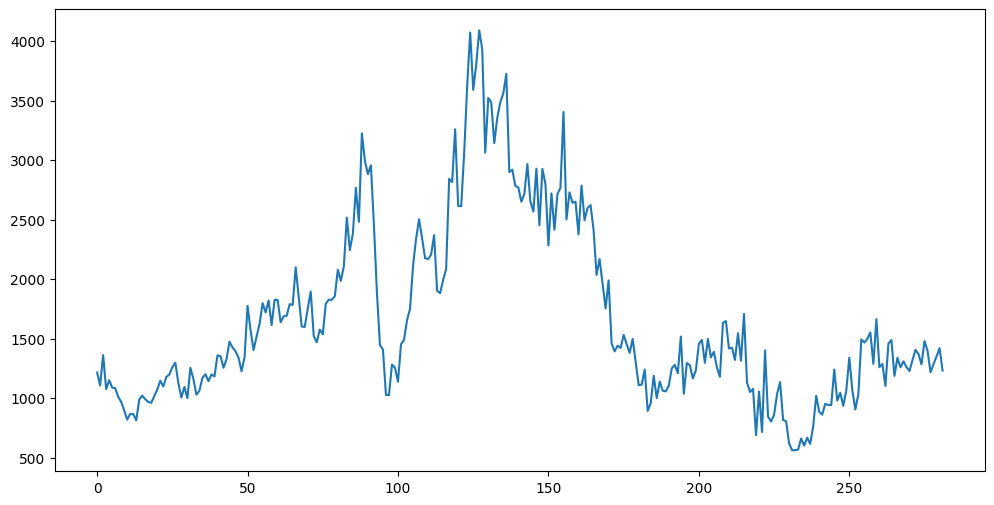

In [ ]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Peramalan-LSTM_75-25/main/Ekspor-Migas-2001-2024.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')
plt.plot(dataset)

In [ ]:
# Pembagian data
#train_size = int(len(dataset)*0.75)
train_size = 211
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
time_steps = 1
last_row_train = train[-time_steps:]
test = np.concatenate([last_row_train, test], axis=0)

In [ ]:
ytest = test
ytrain = train

In [ ]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit(dataset)

train = scaled_data.transform(train)
test = scaled_data.transform(test)

In [ ]:
# Fungsi untuk membuat dataset
def create_dataset (X, y, time_steps = time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
X_test, y_test = create_dataset(test, test)
X_train, y_train = create_dataset(train, train)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (210, 1, 1)
y_train.shape:  (210, 1)
X_test.shape:  (71, 1, 1)
y_test.shape:  (71, 1)


In [ ]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [ ]:
def objective(trial):
    # Define the search space
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model
        model = Sequential([
            LSTM(units=lstm_units, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

        # Print MSE for each fold
        print(f"Fold {fold_index + 1}: MSE = {mse:.4f}")

    # Print average MSE across all folds
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

    return np.mean(cv_scores)

In [14]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-14 01:07:12,771] A new study created in memory with name: no-name-00600f77-9907-4efb-9d87-5ac4d7192951


2/2 [==============================] - 0s 7ms/step
Fold 1: MSE = 0.0580
2/2 [==============================] - 0s 7ms/step
Fold 2: MSE = 0.1227
2/2 [==============================] - 0s 10ms/step
Fold 3: MSE = 0.3482
2/2 [==============================] - 0s 8ms/step
Fold 4: MSE = 0.1115


2/2 [==============================] - 0s 10ms/step


[I 2024-08-14 01:08:28,020] Trial 0 finished with value: 0.12887856364250183 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.12887856364250183.


Fold 5: MSE = 0.0040
Average MSE: 0.1289


2/2 [==============================] - 1s 12ms/step
Fold 1: MSE = 0.0224
2/2 [==============================] - 0s 7ms/step
Fold 2: MSE = 0.0488
2/2 [==============================] - 0s 6ms/step
Fold 3: MSE = 0.1326
2/2 [==============================] - 1s 12ms/step
Fold 4: MSE = 0.0087
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:09:13,452] Trial 1 finished with value: 0.04342900589108467 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.04342900589108467.


Fold 5: MSE = 0.0047
Average MSE: 0.0434
2/2 [==============================] - 0s 7ms/step
Fold 1: MSE = 0.0188
2/2 [==============================] - 0s 6ms/step
Fold 2: MSE = 0.0060
2/2 [==============================] - 0s 6ms/step
Fold 3: MSE = 0.0118
2/2 [==============================] - 0s 6ms/step
Fold 4: MSE = 0.0165
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:09:46,246] Trial 2 finished with value: 0.011151062324643135 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.011151062324643135.


Fold 5: MSE = 0.0028
Average MSE: 0.0112
2/2 [==============================] - 0s 7ms/step
Fold 1: MSE = 0.0099
2/2 [==============================] - 1s 6ms/step
Fold 2: MSE = 0.0060
2/2 [==============================] - 1s 7ms/step
Fold 3: MSE = 0.0134
2/2 [==============================] - 0s 7ms/step
Fold 4: MSE = 0.0114
2/2 [==============================] - 0s 13ms/step


[I 2024-08-14 01:10:26,696] Trial 3 finished with value: 0.009707902558147907 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 3 with value: 0.009707902558147907.


Fold 5: MSE = 0.0078
Average MSE: 0.0097
2/2 [==============================] - 0s 6ms/step
Fold 1: MSE = 0.0228
2/2 [==============================] - 1s 8ms/step
Fold 2: MSE = 0.0524
2/2 [==============================] - 0s 6ms/step
Fold 3: MSE = 0.2019
2/2 [==============================] - 0s 6ms/step
Fold 4: MSE = 0.0288
2/2 [==============================] - 0s 6ms/step


[I 2024-08-14 01:10:56,486] Trial 4 finished with value: 0.06848070025444031 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.009707902558147907.


Fold 5: MSE = 0.0366
Average MSE: 0.0685
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0381
2/2 [==============================] - 0s 6ms/step
Fold 2: MSE = 0.0853
2/2 [==============================] - 0s 6ms/step
Fold 3: MSE = 0.2502
2/2 [==============================] - 0s 6ms/step
Fold 4: MSE = 0.0503
2/2 [==============================] - 0s 5ms/step


[I 2024-08-14 01:11:29,480] Trial 5 finished with value: 0.09071063250303268 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.009707902558147907.


Fold 5: MSE = 0.0297
Average MSE: 0.0907
2/2 [==============================] - 0s 7ms/step
Fold 1: MSE = 0.0198
2/2 [==============================] - 0s 6ms/step
Fold 2: MSE = 0.0441
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.1578
2/2 [==============================] - 0s 8ms/step
Fold 4: MSE = 0.0118
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:12:19,201] Trial 6 finished with value: 0.04831409454345703 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.009707902558147907.


Fold 5: MSE = 0.0080
Average MSE: 0.0483
2/2 [==============================] - 0s 6ms/step
Fold 1: MSE = 0.0256
2/2 [==============================] - 1s 8ms/step
Fold 2: MSE = 0.0082
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0104
2/2 [==============================] - 0s 7ms/step
Fold 4: MSE = 0.0076
2/2 [==============================] - 1s 6ms/step


[I 2024-08-14 01:12:56,574] Trial 7 finished with value: 0.01134329754859209 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.009707902558147907.


Fold 5: MSE = 0.0049
Average MSE: 0.0113
2/2 [==============================] - 1s 16ms/step
Fold 1: MSE = 0.0661
2/2 [==============================] - 0s 7ms/step
Fold 2: MSE = 0.1375
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.3828
2/2 [==============================] - 0s 5ms/step
Fold 4: MSE = 0.1401
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:13:53,465] Trial 8 finished with value: 0.1458413302898407 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.009707902558147907.


Fold 5: MSE = 0.0027
Average MSE: 0.1458
2/2 [==============================] - 0s 7ms/step
Fold 1: MSE = 0.0245
2/2 [==============================] - 0s 9ms/step
Fold 2: MSE = 0.0565
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.1794
2/2 [==============================] - 0s 8ms/step
Fold 4: MSE = 0.0275
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:14:30,587] Trial 9 finished with value: 0.06287745386362076 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.009707902558147907.


Fold 5: MSE = 0.0265
Average MSE: 0.0629
2/2 [==============================] - 0s 9ms/step
Fold 1: MSE = 0.0161
2/2 [==============================] - 1s 12ms/step
Fold 2: MSE = 0.0066
2/2 [==============================] - 0s 9ms/step
Fold 3: MSE = 0.0099
2/2 [==============================] - 0s 7ms/step
Fold 4: MSE = 0.0081
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:15:03,554] Trial 10 finished with value: 0.008837690576910973 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.008837690576910973.


Fold 5: MSE = 0.0035
Average MSE: 0.0088
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0186
2/2 [==============================] - 0s 7ms/step
Fold 2: MSE = 0.0060
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0120
2/2 [==============================] - 1s 10ms/step
Fold 4: MSE = 0.0085
2/2 [==============================] - 0s 12ms/step


[I 2024-08-14 01:15:40,072] Trial 11 finished with value: 0.009703991934657097 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.008837690576910973.


Fold 5: MSE = 0.0034
Average MSE: 0.0097
2/2 [==============================] - 0s 5ms/step
Fold 1: MSE = 0.0188
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0059
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0100
2/2 [==============================] - 0s 7ms/step
Fold 4: MSE = 0.0081
2/2 [==============================] - 0s 9ms/step


[I 2024-08-14 01:16:14,991] Trial 12 finished with value: 0.009144644252955914 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.008837690576910973.


Fold 5: MSE = 0.0030
Average MSE: 0.0091
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0111
2/2 [==============================] - 0s 7ms/step
Fold 2: MSE = 0.0059
2/2 [==============================] - 0s 5ms/step
Fold 3: MSE = 0.0162
2/2 [==============================] - 0s 10ms/step
Fold 4: MSE = 0.0107
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:16:49,405] Trial 13 finished with value: 0.009405592456459999 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.008837690576910973.


Fold 5: MSE = 0.0032
Average MSE: 0.0094
2/2 [==============================] - 0s 7ms/step
Fold 1: MSE = 0.0213
2/2 [==============================] - 1s 10ms/step
Fold 2: MSE = 0.0058
2/2 [==============================] - 0s 9ms/step
Fold 3: MSE = 0.0101
2/2 [==============================] - 1s 6ms/step
Fold 4: MSE = 0.0082
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:17:22,694] Trial 14 finished with value: 0.009618287906050682 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.008837690576910973.


Fold 5: MSE = 0.0026
Average MSE: 0.0096
2/2 [==============================] - 1s 9ms/step
Fold 1: MSE = 0.0134
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0060
2/2 [==============================] - 1s 7ms/step
Fold 3: MSE = 0.0124
2/2 [==============================] - 0s 8ms/step
Fold 4: MSE = 0.0083
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:18:03,093] Trial 15 finished with value: 0.008611422032117844 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.008611422032117844.


Fold 5: MSE = 0.0029
Average MSE: 0.0086
2/2 [==============================] - 0s 7ms/step
Fold 1: MSE = 0.0180
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0224
2/2 [==============================] - 0s 9ms/step
Fold 3: MSE = 0.0567
2/2 [==============================] - 0s 11ms/step
Fold 4: MSE = 0.0084
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:18:46,300] Trial 16 finished with value: 0.02234022505581379 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.008611422032117844.


Fold 5: MSE = 0.0062
Average MSE: 0.0223
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0085
2/2 [==============================] - 1s 11ms/step
Fold 2: MSE = 0.0064
2/2 [==============================] - 0s 7ms/step
Fold 3: MSE = 0.0109
2/2 [==============================] - 0s 8ms/step
Fold 4: MSE = 0.0081
2/2 [==============================] - 1s 7ms/step


[I 2024-08-14 01:19:26,697] Trial 17 finished with value: 0.007347235921770334 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.007347235921770334.


Fold 5: MSE = 0.0028
Average MSE: 0.0073
2/2 [==============================] - 0s 11ms/step
Fold 1: MSE = 0.0183
2/2 [==============================] - 0s 7ms/step
Fold 2: MSE = 0.0064
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0109
2/2 [==============================] - 0s 8ms/step
Fold 4: MSE = 0.0082
2/2 [==============================] - 0s 12ms/step


[I 2024-08-14 01:20:09,639] Trial 18 finished with value: 0.009260079823434353 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.007347235921770334.


Fold 5: MSE = 0.0025
Average MSE: 0.0093
2/2 [==============================] - 0s 7ms/step
Fold 1: MSE = 0.0221
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0067
2/2 [==============================] - 1s 8ms/step
Fold 3: MSE = 0.0114
2/2 [==============================] - 0s 9ms/step
Fold 4: MSE = 0.0082
2/2 [==============================] - 0s 11ms/step


[I 2024-08-14 01:20:48,461] Trial 19 finished with value: 0.010211203247308731 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.007347235921770334.


Fold 5: MSE = 0.0026
Average MSE: 0.0102
2/2 [==============================] - 0s 6ms/step
Fold 1: MSE = 0.0202
2/2 [==============================] - 0s 6ms/step
Fold 2: MSE = 0.0296
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0165
2/2 [==============================] - 0s 7ms/step
Fold 4: MSE = 0.0084
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:21:40,704] Trial 20 finished with value: 0.015459624119102955 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.007347235921770334.


Fold 5: MSE = 0.0027
Average MSE: 0.0155
2/2 [==============================] - 0s 6ms/step
Fold 1: MSE = 0.0060
2/2 [==============================] - 0s 9ms/step
Fold 2: MSE = 0.0063
2/2 [==============================] - 1s 8ms/step
Fold 3: MSE = 0.0110
2/2 [==============================] - 0s 8ms/step
Fold 4: MSE = 0.0083
2/2 [==============================] - 1s 13ms/step


[I 2024-08-14 01:22:17,651] Trial 21 finished with value: 0.006968018598854542 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0033
Average MSE: 0.0070
2/2 [==============================] - 0s 6ms/step
Fold 1: MSE = 0.0096
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0062
2/2 [==============================] - 1s 15ms/step
Fold 3: MSE = 0.0105
2/2 [==============================] - 0s 9ms/step
Fold 4: MSE = 0.0085
2/2 [==============================] - 0s 12ms/step


[I 2024-08-14 01:22:58,116] Trial 22 finished with value: 0.0074892109259963036 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0026
Average MSE: 0.0075
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0116
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0068
2/2 [==============================] - 0s 6ms/step
Fold 3: MSE = 0.0109
2/2 [==============================] - 1s 6ms/step
Fold 4: MSE = 0.0083
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:23:43,273] Trial 23 finished with value: 0.008019309490919113 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0025
Average MSE: 0.0080
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0101
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0062
2/2 [==============================] - 0s 6ms/step
Fold 3: MSE = 0.0111
2/2 [==============================] - 1s 13ms/step
Fold 4: MSE = 0.0083
2/2 [==============================] - 1s 7ms/step


[I 2024-08-14 01:24:20,390] Trial 24 finished with value: 0.007739221211522818 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0031
Average MSE: 0.0077
2/2 [==============================] - 0s 7ms/step
Fold 1: MSE = 0.0144
2/2 [==============================] - 0s 7ms/step
Fold 2: MSE = 0.0062
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0110
2/2 [==============================] - 0s 7ms/step
Fold 4: MSE = 0.0085
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:24:58,191] Trial 25 finished with value: 0.00866243802011013 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0031
Average MSE: 0.0087
2/2 [==============================] - 0s 6ms/step
Fold 1: MSE = 0.0147
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0062
2/2 [==============================] - 0s 6ms/step
Fold 3: MSE = 0.0107
2/2 [==============================] - 0s 6ms/step
Fold 4: MSE = 0.0086
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:25:38,041] Trial 26 finished with value: 0.008559353649616241 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0026
Average MSE: 0.0086
2/2 [==============================] - 0s 6ms/step
Fold 1: MSE = 0.0086
2/2 [==============================] - 1s 6ms/step
Fold 2: MSE = 0.0063
2/2 [==============================] - 0s 6ms/step
Fold 3: MSE = 0.0103
2/2 [==============================] - 1s 10ms/step
Fold 4: MSE = 0.0083
2/2 [==============================] - 0s 6ms/step


[I 2024-08-14 01:26:14,255] Trial 27 finished with value: 0.007306436542421579 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0031
Average MSE: 0.0073
2/2 [==============================] - 1s 9ms/step
Fold 1: MSE = 0.0146
2/2 [==============================] - 0s 6ms/step
Fold 2: MSE = 0.0063
2/2 [==============================] - 1s 9ms/step
Fold 3: MSE = 0.0115
2/2 [==============================] - 0s 6ms/step
Fold 4: MSE = 0.0085
2/2 [==============================] - 0s 6ms/step


[I 2024-08-14 01:26:49,200] Trial 28 finished with value: 0.008758868090808392 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0028
Average MSE: 0.0088
2/2 [==============================] - 0s 6ms/step
Fold 1: MSE = 0.0177
2/2 [==============================] - 0s 7ms/step
Fold 2: MSE = 0.0325
2/2 [==============================] - 0s 7ms/step
Fold 3: MSE = 0.0723
2/2 [==============================] - 0s 7ms/step
Fold 4: MSE = 0.0084
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:27:30,337] Trial 29 finished with value: 0.027247140184044838 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0054
Average MSE: 0.0272
2/2 [==============================] - 0s 9ms/step
Fold 1: MSE = 0.0146
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0317
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0904
2/2 [==============================] - 0s 6ms/step
Fold 4: MSE = 0.0089
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:28:10,093] Trial 30 finished with value: 0.030904417857527733 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0089
Average MSE: 0.0309
2/2 [==============================] - 1s 6ms/step
Fold 1: MSE = 0.0116
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0063
2/2 [==============================] - 0s 7ms/step
Fold 3: MSE = 0.0106
2/2 [==============================] - 0s 6ms/step
Fold 4: MSE = 0.0089
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:28:54,026] Trial 31 finished with value: 0.008063482120633125 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0030
Average MSE: 0.0081
2/2 [==============================] - 0s 10ms/step
Fold 1: MSE = 0.0091
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0063
2/2 [==============================] - 1s 9ms/step
Fold 3: MSE = 0.0107
2/2 [==============================] - 0s 7ms/step
Fold 4: MSE = 0.0082
2/2 [==============================] - 1s 9ms/step


[I 2024-08-14 01:29:36,042] Trial 32 finished with value: 0.007501593325287104 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0032
Average MSE: 0.0075
2/2 [==============================] - 1s 7ms/step
Fold 1: MSE = 0.0109
2/2 [==============================] - 0s 7ms/step
Fold 2: MSE = 0.0061
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0102
2/2 [==============================] - 0s 7ms/step
Fold 4: MSE = 0.0082
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:30:18,222] Trial 33 finished with value: 0.007740658707916737 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0033
Average MSE: 0.0077
2/2 [==============================] - 0s 7ms/step
Fold 1: MSE = 0.0070
2/2 [==============================] - 0s 7ms/step
Fold 2: MSE = 0.0066
2/2 [==============================] - 1s 7ms/step
Fold 3: MSE = 0.0107
2/2 [==============================] - 0s 8ms/step
Fold 4: MSE = 0.0085
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:30:57,894] Trial 34 finished with value: 0.007169367279857397 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0030
Average MSE: 0.0072
2/2 [==============================] - 0s 6ms/step
Fold 1: MSE = 0.0154
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0062
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0108
2/2 [==============================] - 0s 8ms/step
Fold 4: MSE = 0.0081
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:31:39,589] Trial 35 finished with value: 0.008716817945241928 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0031
Average MSE: 0.0087
2/2 [==============================] - 0s 7ms/step
Fold 1: MSE = 0.0122
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0080
2/2 [==============================] - 0s 7ms/step
Fold 3: MSE = 0.0104
2/2 [==============================] - 1s 13ms/step
Fold 4: MSE = 0.0088
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:32:15,774] Trial 36 finished with value: 0.008649592287838459 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0039
Average MSE: 0.0086
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0163
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0063
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0107
2/2 [==============================] - 0s 8ms/step
Fold 4: MSE = 0.0085
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:32:48,894] Trial 37 finished with value: 0.008930487558245659 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0029
Average MSE: 0.0089
2/2 [==============================] - 0s 6ms/step
Fold 1: MSE = 0.0160
2/2 [==============================] - 0s 7ms/step
Fold 2: MSE = 0.0311
2/2 [==============================] - 0s 6ms/step
Fold 3: MSE = 0.0357
2/2 [==============================] - 0s 6ms/step
Fold 4: MSE = 0.0095
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:33:18,464] Trial 38 finished with value: 0.01911456324160099 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0033
Average MSE: 0.0191
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0224
2/2 [==============================] - 0s 6ms/step
Fold 2: MSE = 0.0522
2/2 [==============================] - 0s 10ms/step
Fold 3: MSE = 0.1099
2/2 [==============================] - 0s 8ms/step
Fold 4: MSE = 0.0091
2/2 [==============================] - 1s 5ms/step


[I 2024-08-14 01:34:07,219] Trial 39 finished with value: 0.039747703820466995 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0051
Average MSE: 0.0397
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0130
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0063
2/2 [==============================] - 0s 9ms/step
Fold 3: MSE = 0.0118
2/2 [==============================] - 1s 10ms/step
Fold 4: MSE = 0.0080
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:34:44,097] Trial 40 finished with value: 0.008449608460068703 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0030
Average MSE: 0.0084
2/2 [==============================] - 0s 11ms/step
Fold 1: MSE = 0.0098
2/2 [==============================] - 0s 9ms/step
Fold 2: MSE = 0.0061
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0104
2/2 [==============================] - 1s 7ms/step
Fold 4: MSE = 0.0081
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:35:35,177] Trial 41 finished with value: 0.007569030858576298 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0033
Average MSE: 0.0076
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0142
2/2 [==============================] - 1s 13ms/step
Fold 2: MSE = 0.0067
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0124
2/2 [==============================] - 1s 9ms/step
Fold 4: MSE = 0.0090
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:36:21,378] Trial 42 finished with value: 0.008995448239147663 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0026
Average MSE: 0.0090
2/2 [==============================] - 0s 15ms/step
Fold 1: MSE = 0.0103
2/2 [==============================] - 0s 9ms/step
Fold 2: MSE = 0.0063
2/2 [==============================] - 1s 13ms/step
Fold 3: MSE = 0.0110
2/2 [==============================] - 0s 11ms/step
Fold 4: MSE = 0.0084
2/2 [==============================] - 0s 7ms/step


[I 2024-08-14 01:36:58,972] Trial 43 finished with value: 0.007837644778192043 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0032
Average MSE: 0.0078
2/2 [==============================] - 1s 5ms/step
Fold 1: MSE = 0.0242
2/2 [==============================] - 1s 13ms/step
Fold 2: MSE = 0.0564
2/2 [==============================] - 0s 9ms/step
Fold 3: MSE = 0.1859
2/2 [==============================] - 0s 10ms/step
Fold 4: MSE = 0.0345
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:37:58,568] Trial 44 finished with value: 0.0665004700422287 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0316
Average MSE: 0.0665
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0079
2/2 [==============================] - 1s 7ms/step
Fold 2: MSE = 0.0059
2/2 [==============================] - 0s 8ms/step
Fold 3: MSE = 0.0121
2/2 [==============================] - 1s 8ms/step
Fold 4: MSE = 0.0082
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:38:34,656] Trial 45 finished with value: 0.007425440009683371 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0031
Average MSE: 0.0074
2/2 [==============================] - 0s 11ms/step
Fold 1: MSE = 0.0202
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0068
2/2 [==============================] - 1s 11ms/step
Fold 3: MSE = 0.0124
2/2 [==============================] - 0s 8ms/step
Fold 4: MSE = 0.0078
2/2 [==============================] - 1s 7ms/step


[I 2024-08-14 01:39:08,530] Trial 46 finished with value: 0.010103294625878334 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0033
Average MSE: 0.0101
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0163
2/2 [==============================] - 0s 9ms/step
Fold 2: MSE = 0.0095
2/2 [==============================] - 0s 7ms/step
Fold 3: MSE = 0.0101
2/2 [==============================] - 0s 7ms/step
Fold 4: MSE = 0.0090
2/2 [==============================] - 0s 8ms/step


[I 2024-08-14 01:39:47,859] Trial 47 finished with value: 0.010530328378081322 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0077
Average MSE: 0.0105
2/2 [==============================] - 0s 8ms/step
Fold 1: MSE = 0.0243
2/2 [==============================] - 0s 8ms/step
Fold 2: MSE = 0.0557
2/2 [==============================] - 0s 9ms/step
Fold 3: MSE = 0.1286
2/2 [==============================] - 0s 7ms/step
Fold 4: MSE = 0.0089
2/2 [==============================] - 0s 10ms/step


[I 2024-08-14 01:40:33,442] Trial 48 finished with value: 0.045179810374975204 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0083
Average MSE: 0.0452
2/2 [==============================] - 0s 9ms/step
Fold 1: MSE = 0.0149
2/2 [==============================] - 1s 7ms/step
Fold 2: MSE = 0.0058
2/2 [==============================] - 0s 11ms/step
Fold 3: MSE = 0.0115
2/2 [==============================] - 0s 9ms/step
Fold 4: MSE = 0.0093
2/2 [==============================] - 0s 10ms/step


[I 2024-08-14 01:41:06,561] Trial 49 finished with value: 0.008908184245228767 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 21 with value: 0.006968018598854542.


Fold 5: MSE = 0.0030
Average MSE: 0.0089
Best parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}
Best value: 0.006968018598854542


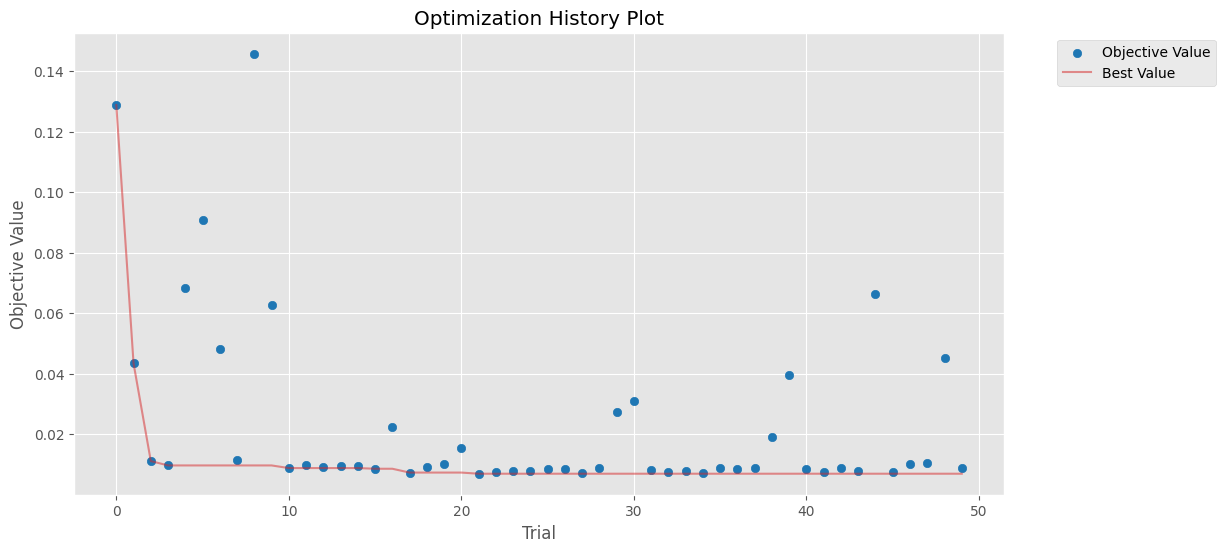

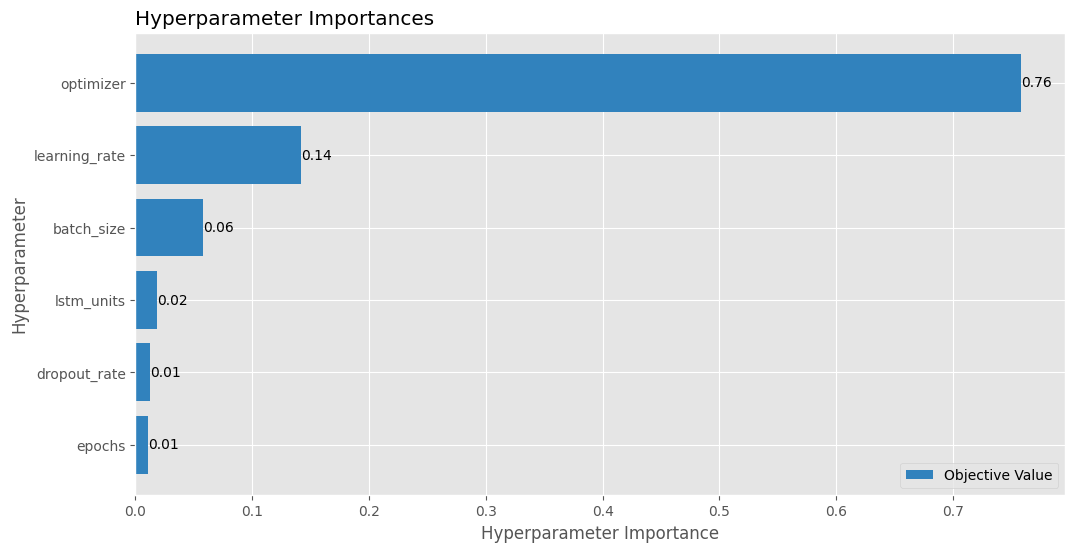

In [15]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [16]:
# Train final model with best parameters
best_params = study.best_params
model = Sequential([
    LSTM(units=best_params['lstm_units'], input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/150
6/6 [==============================] - 3s 124ms/step - loss: 0.1072 - val_loss: 0.0116
Epoch 2/150
6/6 [==============================] - 0s 13ms/step - loss: 0.0335 - val_loss: 0.0620
Epoch 3/150
6/6 [==============================] - 0s 13ms/step - loss: 0.0297 - val_loss: 0.0133
Epoch 4/150
6/6 [==============================] - 0s 10ms/step - loss: 0.0178 - val_loss: 0.0049
Epoch 5/150
6/6 [==============================] - 0s 13ms/step - loss: 0.0138 - val_loss: 0.0088
Epoch 6/150
6/6 [==============================] - 0s 13ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 7/150
6/6 [==============================] - 0s 13ms/step - loss: 0.0082 - val_loss: 0.0035
Epoch 8/150
6/6 [==============================] - 0s 13ms/step - loss: 0.0076 - val_loss: 0.0031
Epoch 9/150
6/6 [==============================] - 0s 17ms/step - loss: 0.0062 - val_loss: 0.0036
Epoch 10/150
6/6 [==============================] - 0s 17ms/step - loss: 0.0063 - val_loss: 0.0027
Epoch 11/150
6/6 [

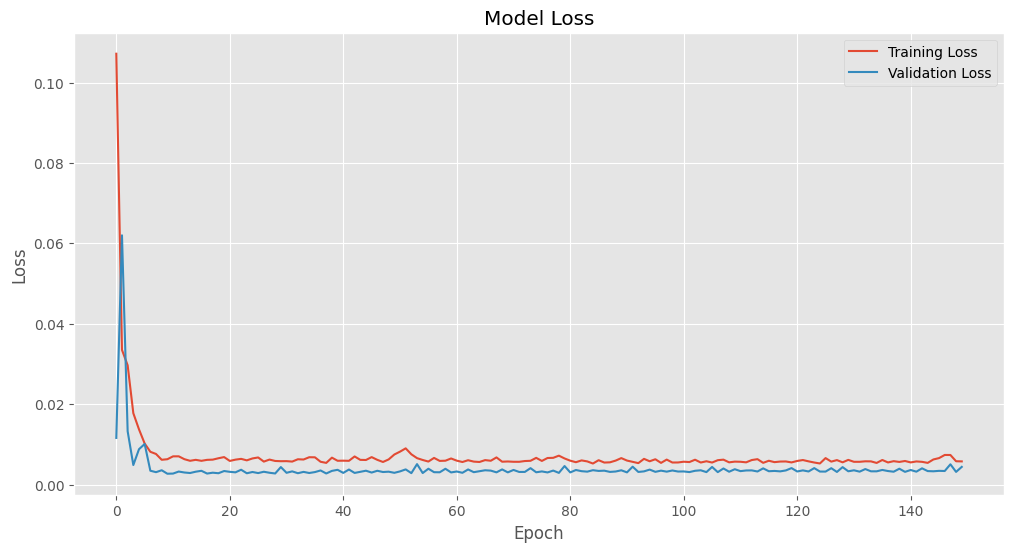

Average Loss: 0.0073


In [17]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [18]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

3/3 [==============================] - 0s 4ms/step


In [19]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [21]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 197.028
Root Mean Square Error: 263.417
Mean Absolute Percentage Error: 11.251%

evaluasi model data test:
Mean Absolute Error: 187.837
Root Mean Square Error: 250.052
Mean Absolute Percentage Error: 17.688%



In [22]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

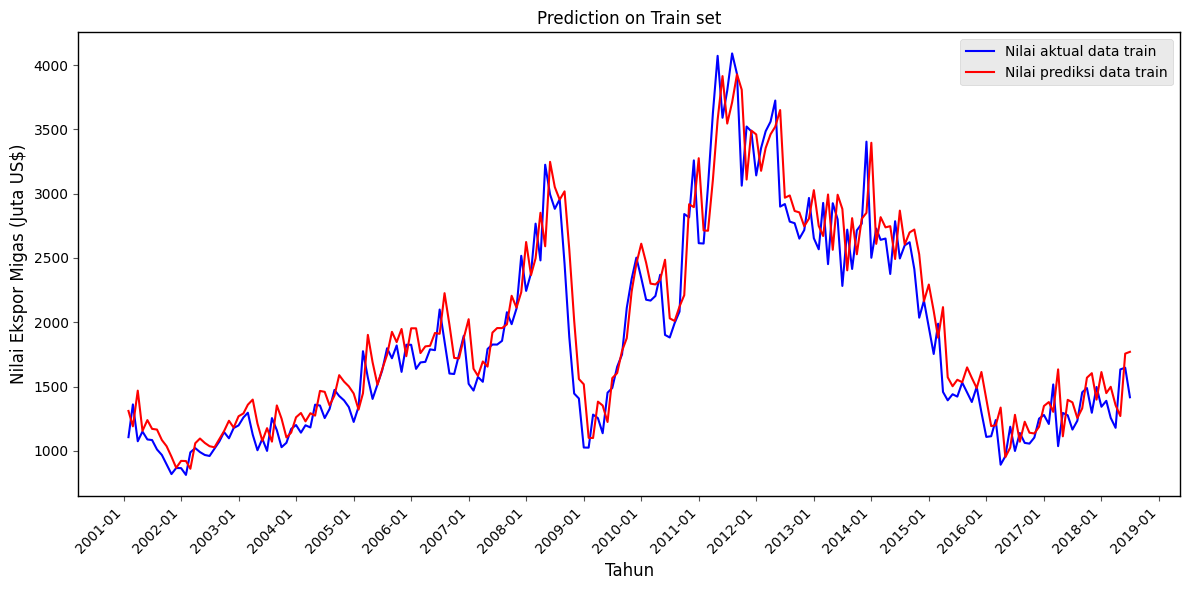

In [23]:
import matplotlib.dates as mdates
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

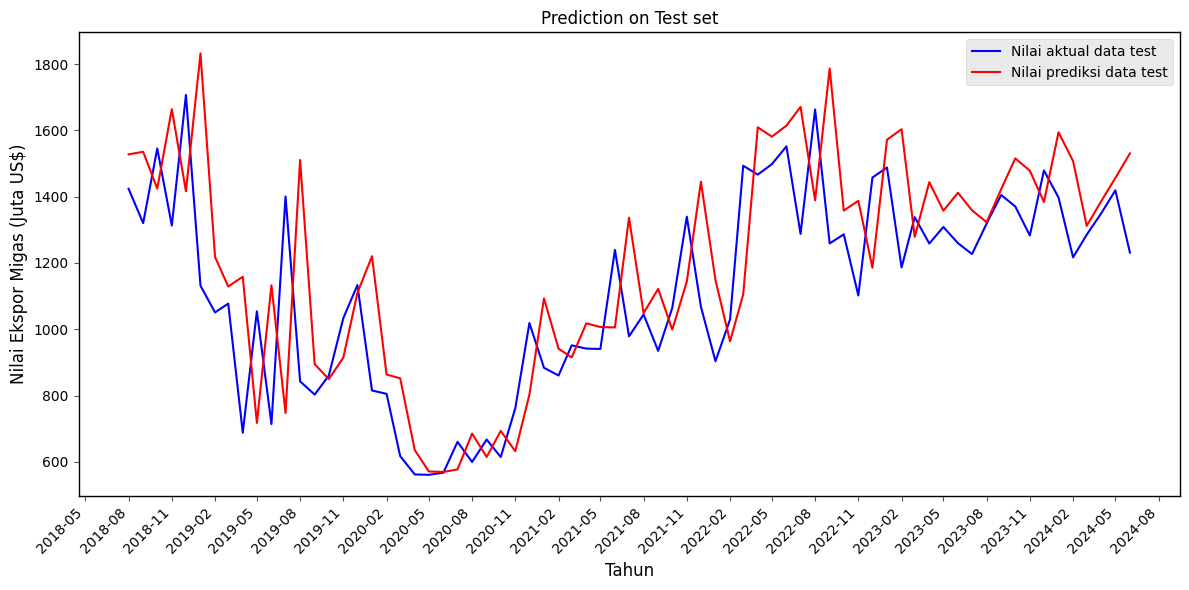

In [24]:
# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

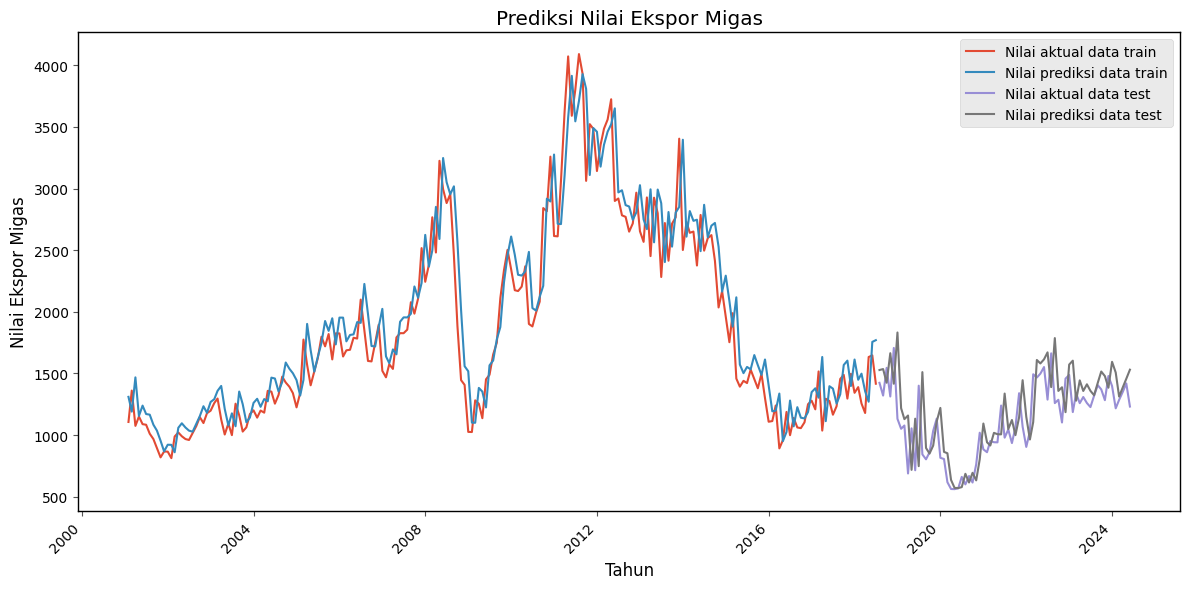

In [25]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 34ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-07-01                     1327.698120
1  2024-08-01                     1432.373169
2  2024-09-01                     1544.594238
3  2024-10-01                     1663.359497
4  2024-11-01                     1787.293091
5  2024-12-01                     1914.679199
6  2025-01-01                     2043.537964
7  2025-02-01                     2171.738770
8  2025-03-01                     2297.140137
9  2025-04-01                     2417.736328
10 2025-05-01                     2531.789307
11 2025-06-01                     2637.927734


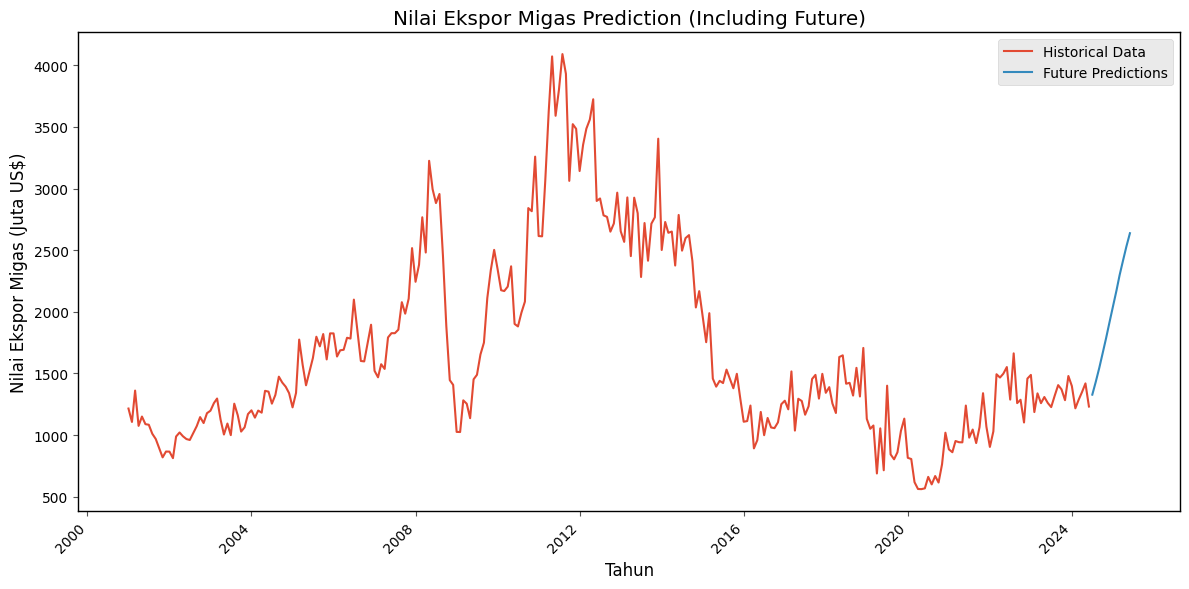

In [26]:
scaled_dt = scaler.fit_transform(dataset)

# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_dt[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()


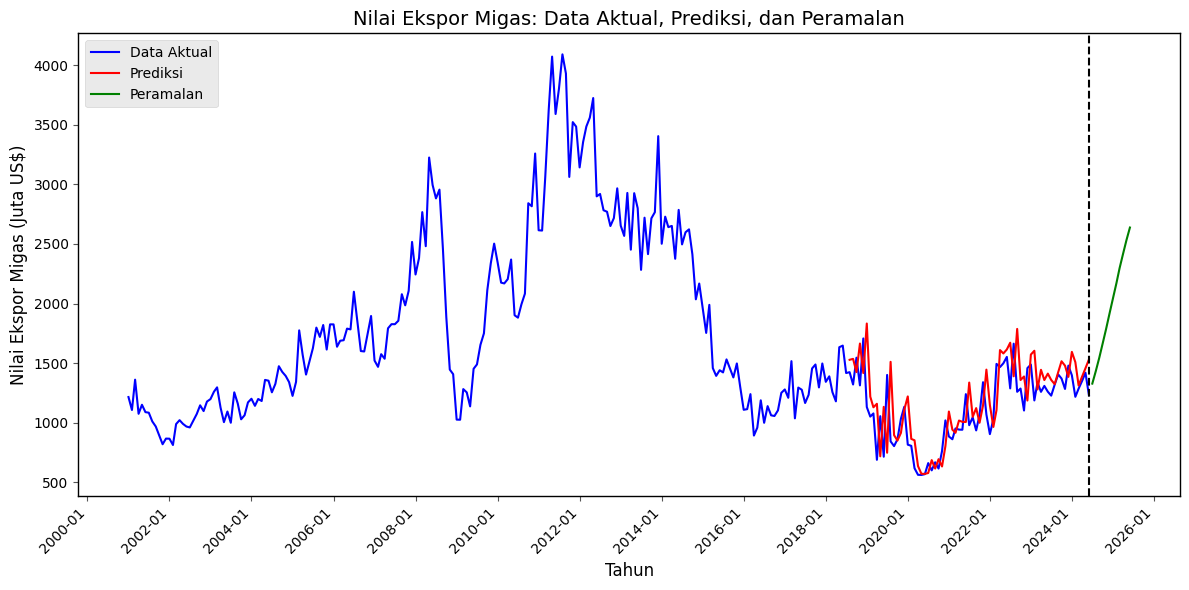

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [28]:
!pip install openpyxl

In [29]:
forecast_df.to_excel('forecast_2024-75:25_h1t1.xlsx', index=False)
from google.colab import files
files.download('forecast_2024-75:25_h1t1.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_2024-75:25_h1t1.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_2024-75:25_h1t1.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>